# Nanocourse - Genomic analysis using sketching techniques




## Sketching

A *data sketch* of data $X$ is the output of a (randomized) function $f$ s.t.:
 - $|f(X)| \subseteq o(|X|)$
 - $f$ perserves some properties of $X$ e.g. approximation of the number of distinct elements
 - $f$ preserves certain similarity measures e.g. number of shared elements
 - $f(X)$ allows to be updated efficiently


## Counting distinct elements of a set

In an **online** setting (stream)


### Naive solution

Using a Hashmap or a Bitvector

**TODO:** Implement naive_counting() in naive_couting.cpp

Test your implementation by running
```
./build/source/naivecounting data/ecoli1_k31_ust.fa.gz
```
The output should be
```
Distinct kmers: 4877400
```
How much memory consumption do you expect?

Let us check that in practice:

In [1]:
import os
from evaluate.track import track_memory_and_runtime

file = "data/ecoli1_k31_ust.fa.gz"
file_size = os.path.getsize(file)/(1024*1024)
_,memory,_ = track_memory_and_runtime("build/source/naivecounting", file)
print("File size: %.1fMB" % file_size)
print("Memory consumption: %.1fMB" % memory)

File size: 1.4MB
Memory consumption: 254.2MB


#### Observation:
- space consumption linear w.r.t. number distinct elements
- impractical for big data

-> approximate/probabilistic counting

### Flajolet-Martin’s algorithm

#### Recall:

Let $\mathcal{M}$ be a multiset of uniformly distributed random numbers.
 - The cardinality of $\mathcal{M}$ can be estimated by the maximum number of leading zeros in the binary representation of each number in $\mathcal{M}$.
 - If max leading zeros is $l$, one exepcts $2^l$ distinct elements
(the probability of observing a binary encoded number beginning with $k$ zeroes followed by a one is $1/2^{(k+1)}$ ).

#### Algorithm:

- Map each element $x$ to hash $h(x)$
- remember the maximum number $l$ of leading 0-bits seen in any $h(x)$
- estimate cardinality by $2^l$

<!-- % $\Psi \approx 0.77351$ is a normalization constant. -->

**TODO**
- Implement flajolet_martin() in flajolet_martin.cpp
- Test it by running
```
./build/source/naivecounting data/ecoli1_k31_ust.fa.gz
```
Let us compare run time, space consumption, and accuracy to exact algorithm:

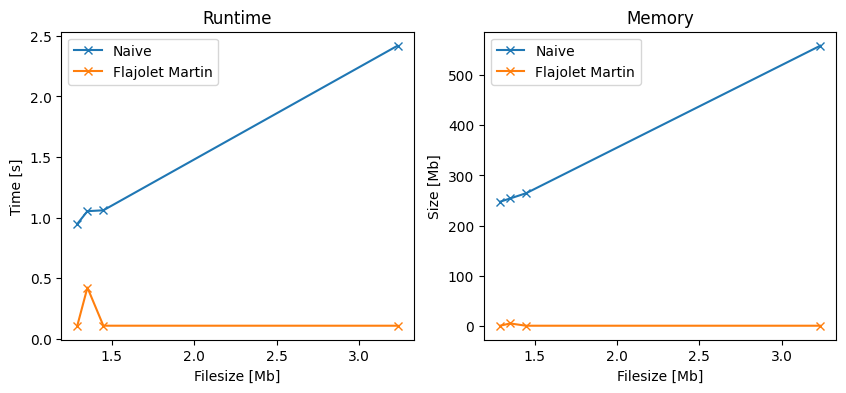

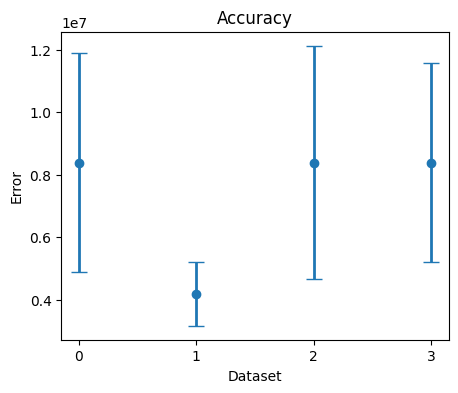

Error: 49.8+-26.6%


In [2]:
import numpy as np
from evaluate.plots import plot_performance, plot_accuracy_FM, plot_accuracies

files = ["data/ecoli1_k31_ust.fa.gz", "data/ecoli2_k31_ust.fa.gz", "data/ecoli4_k31_ust.fa.gz",
         "data/yeast.k31.unitigs.fa.ust.fa.gz"]

naive_results, fm_results = [], []
for file in files:
    naive_results.append(track_memory_and_runtime("build/source/naivecounting", file))
    fm_results.append(track_memory_and_runtime("build/source/flajoletmartin", file))

file_sizes = [os.path.getsize(file) for file in files]
results = np.array([naive_results, fm_results])
algorithms = ["Naive", "Flajolet Martin"]

plot_performance(results, algorithms, file_sizes)
plot_accuracy_FM(results, algorithms)
errors=np.abs(results[1,:,2] - results[0,:,2])/results[0,:,2]
print("Error: %.1f+-%.1f%%" % (np.mean(errors)*100, np.std(errors)*100))

#### Observations:
- Large variance! How could you compensate that?
- Less space consumption: hash $h(x) \rightarrow [0,L]$ requires $\log(L) \approx \log(n)$ space for $n$ distinct elements i.e. exponential less space w.r.t. sequence length $n$


### HyperLogLog

#### Refinement:
- split $\mathcal{M}$ into $m$ subsets
- estimate cardinalities of subsets
- return mean

The normalized version of the harmonic mean is the estimate

$$E:=\frac{\alpha_m m^2}{\sum_{j=1}^m 2^{-M(j)}}.$$

for $m$ subsets $M(i)$ and normalization constant $\alpha_m \approx 0.7$.

**TODO:** Implement hyperloglog() in hyperloglog.cpp

Let us compare run time, space consumption, and accuracy to Flajolet-Martin and the exact algorithm:

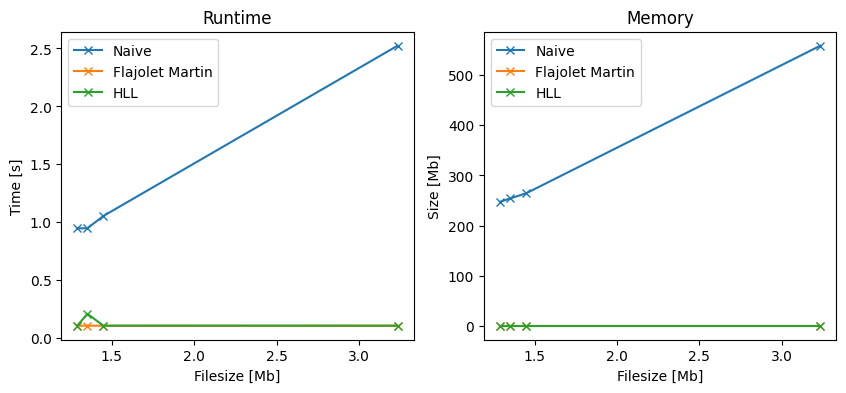

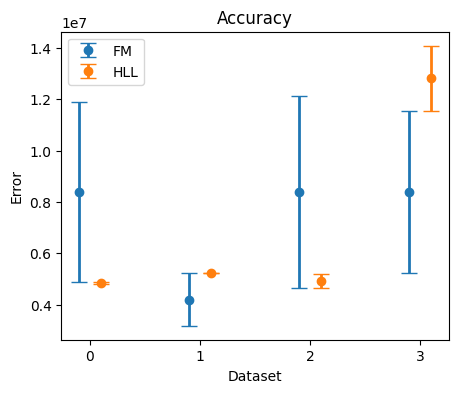

Total Runtime Hashtable: 5.5s, FM: 0.4s, HLL: 0.5s
Maximum Memory Hashtable: 558.9Mb, FM: 0.0Mb, HLL: 0.0Mb
Error Flajolet Martin: 49.8+-26.6%
Error HyperLogLog: 4.4+-4.3%


In [3]:
naive_results, fm_results, hll_results = [], [], []
for file in files:
    naive_results.append(track_memory_and_runtime("build/source/naivecounting", file))
    fm_results.append(track_memory_and_runtime("build/source/flajoletmartin", file))
    hll_results.append(track_memory_and_runtime("build/source/hyperloglog", file))

file_sizes = [os.path.getsize(file) for file in files]
results = np.array([naive_results, fm_results, hll_results])
algorithms = ["Naive", "Flajolet Martin", "HLL"]

plot_performance(results, algorithms, file_sizes)
plot_accuracies(results, algorithms)
error_fm=np.abs(results[1,:,2] - results[0,:,2])/results[0,:,2]
error_hll=np.abs(results[2,:,2] - results[0,:,2])/results[0,:,2]
print("Total Runtime Hashtable: %.1fs, FM: %.1fs, HLL: %.1fs" % (np.sum(results[0,:,0]), np.sum(results[1,:,0]), np.sum(results[2,:,0])))
print("Maximum Memory Hashtable: %.1fMb, FM: %.1fMb, HLL: %.1fMb" % (np.max(results[0,:,1]), np.max(results[1,:,1]), np.max(results[2,:,1])))
print("Error Flajolet Martin: %.1f+-%.1f%%" % (np.mean(error_fm)*100, np.std(error_fm)*100))
print("Error HyperLogLog: %.1f+-%.1f%%" % (np.mean(error_hll)*100, np.std(error_hll)*100))

#### Observations:

- Smaller variance
- Less space consumption: $O(\log \log n)$


## Set Similarity

(Dis-)similarity of two sets $A$ and $B$ can be measured with Jaccard similarity
$$
J(A,B) := \frac{|A \cap B|}{|A \cup B|}
$$


### Naive Algorithm

Hashmap or bitvector

**TODO** Implement jaccard_similarity() in jaccard.cpp

Test it by running
```
./build/source/jaccard
```

### Observations
- space consumption linear w.r.t. total number of distinct elements
- comparing $n$ sets requires $O(n^2)$ pairwise comarisons.
- keeping hashmaps of all sets of size $O(m)$ in memory for faster comparison costs $O(n m)$ space.

Impractical for big data.

### Naive Improvement

Randomly sample $p$ percent elements per set and compute Jaccard similarity for them.

**TODO:** Implement jaccard_similarities() in jaccard_sample.cpp

Let us compare run time, space consumption, and accuracy to the exact algorithm:

In [4]:
from evaluate.track import track_memory_and_runtime_similarity
time_jaccard, mem_jaccard, jaccard = track_memory_and_runtime_similarity("build/source/jaccard")

In [5]:
probabilities = [0.1, 0.25, 0.5, 0.75]
results = []
for prob in probabilities:
    results.append(track_memory_and_runtime_similarity("build/source/jaccard_sample", prob))

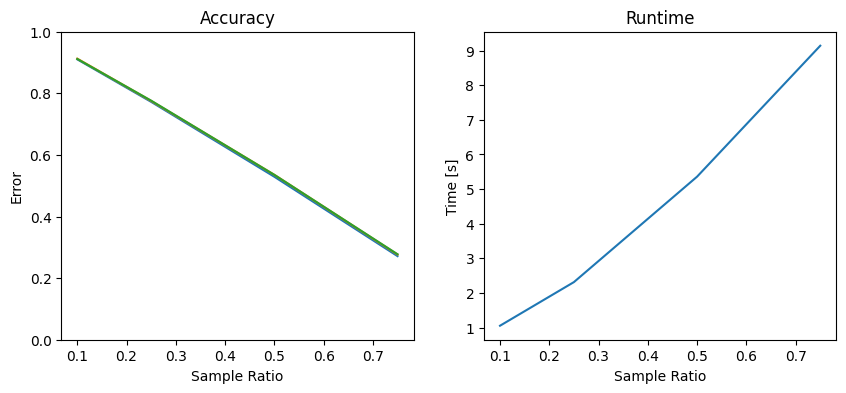

In [6]:
import numpy as np
from evaluate.plots import plot_accuracy_runtime

indices = np.triu_indices(jaccard.shape[0], k=1)
errors = np.empty((len(results), jaccard.shape[0]))
runtimes = np.empty(len(results))
for i, (time, mem, res) in enumerate(results):
    errors[i] = np.abs(res[indices]-jaccard[indices])/jaccard[indices]
    runtimes[i] = time

plot_accuracy_runtime(errors, runtimes, probabilities)

### MinHashing

Let $A,B$ be two sets, $h$ be a hash function, MinHash $h_{\min}(A) := \min \lbrace h(x) \mid x \in A \rbrace$ and
$$
J_h(A,B) := \begin{cases}1, & \text{if } h_{\min}(A) = h_{\min}(B)\\ 0 & \text{otw.}\end{cases},
$$
Then $J_h(A,B)$ is a random estimator of $J(A,B)$, i.e.: $E[J_h(A,B)] = J(A,B)$.
Scince $J_h$ has too high a variance (it is always zero or one), average multiple independent MinHashs estimators.

#### Algorithm:

- sample $h_{\min}$ from $k$ random permutations of $h$
- let $l$ be the number of permutated hash functions with $h_{\min}(A) = h_{\min}(B)$
- estimate $J(A,B)$ by $l/k$

A random permutation of $h$ can be e.g.:
$$
h_i(x) = a_i x + b_i \mod p
$$
for prime number $p$ and random $a_i,b_i \in \lbrace 1,\ldots,p\rbrace$.

**TODO:** Implement minhash_similarity() in minhash.cpp


Let us compare run time and accuracy to exact algorithm:

In [7]:
time_minhash, mem_minhash, minhash = track_memory_and_runtime_similarity("build/source/minhash", 100)
print("Runtime Hashtable: %.1fs, Minhash: %.1fs" % (time_jaccard, time_minhash))
print("Memory Hashtable: %.1fMb, Minhash: %.1fMb" % (mem_jaccard, mem_minhash))
error_minhash = np.abs(minhash[indices]-jaccard[indices])/jaccard[indices]
print("Error: %.1f+-%.1f%%" % (np.mean(error_minhash)*100, np.std(error_minhash)*100))

Runtime Hashtable: 11.3s, Minhash: 1.9s
Memory Hashtable: 919.0Mb, Minhash: 17.3Mb
Error: 9.9+-7.2%


 - For any $\epsilon > 0$ there is a $k \in O(1/\epsilon^2)$ s.t. the expected error is at most $\epsilon$.

 - How many permutations $k$ do you need to have an expected error at most $.05$?

Let us explore the accuracy and run time of MinHash w.r.t. the number of permutations:

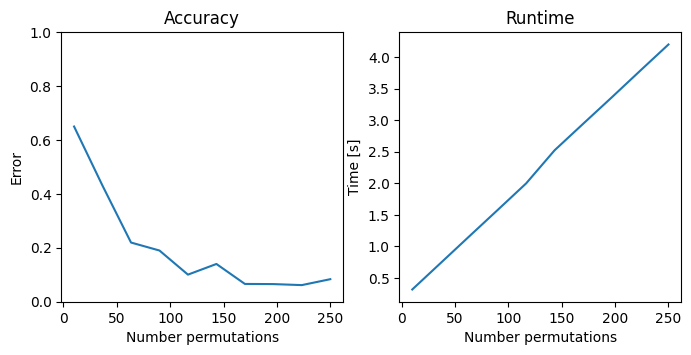

In [8]:
from evaluate.plots import plot_minhash
permutations = np.linspace(10,250,10)
runtimes, errors = [], []
for perms in permutations:
    time, mem, res = track_memory_and_runtime_similarity("build/source/minhash", perms)
    runtimes.append(time)
    errors.append(np.mean(np.abs(res[indices]-jaccard[indices])/jaccard[indices]))
plot_minhash(errors, runtimes, permutations)

 Let us also compare different hash functions:

In [9]:
print("todo")

todo


### FracMinHashing

Let $h: \Omega \Rightarrow [0,H]$ be a hash function for $H \in \mathbb{N}$ and $s \in [0,1]$ be a scaling factor. Then FracMinHash sketch
$$
FRAC_{s}(A) := \{ h(x) \mid x \in A \land h(x) \leq H s \}.
$$
The Containment Index $C(A,B) = \frac{|A \cap B|}{|A|}$ is the estimate of
$$
\hat{C}_s(A,B) = \frac{|FRAC_{s}(A) \cap FRAC_{s}(B)|}{|FRAC_{s}(A)| (1-(1-s)^{|A|})}
$$
where $1/(1-(1-s)^{|A|})$ compensatates the bias.


**TODO:** Implement fracminhash_similarities() in fracMinHash.cpp

Note that the Jaccard similarity
$$
J(A,B) = \frac{C(A,B)|A|}{|A|+|B|-C(A,B)|A|}.
$$

Let us compare run time and accuracy to MinHash:

In [10]:
time_fracminhash, mem_fracminhash, fracminhash = track_memory_and_runtime_similarity("build/source/fracminhash")
print("Runtime MinHash: %.1fs, FracMinHash: %.1fs" % (time_minhash, time_fracminhash))
error_fracminhash = np.abs(fracminhash[indices]-jaccard[indices])/jaccard[indices]
print("Error: %.1f+-%.1f%%" % (np.mean(error_minhash)*100, np.std(error_minhash)*100))
print("Error FracMinHash: %.1f+-%.1f%%" % (np.mean(error_fracminhash)*100, np.std(error_fracminhash)*100))

Runtime MinHash: 1.9s, FracMinHash: 0.3s
Error: 9.9+-7.2%
Error FracMinHash: 2.4+-1.3%


How does the scaling factor influence the accuracy and runtime?

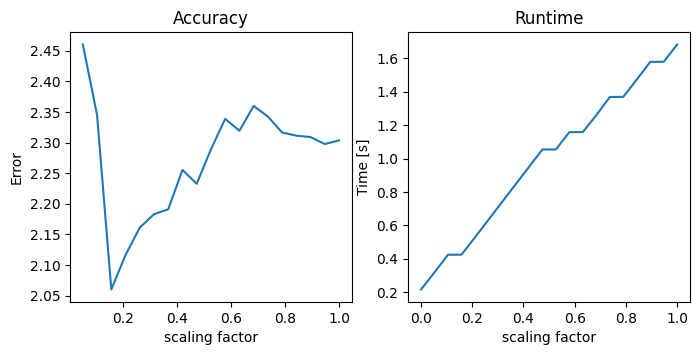

In [15]:
from evaluate.plots import plot_fracminhash
scaling_factors = np.linspace(0, 1, 20)
runtimes, errors = [], []
for scaling_factor in scaling_factors:
    time, mem, res = track_memory_and_runtime_similarity("build/source/fracminhash", scaling_factor)
    runtimes.append(time)
    errors.append(np.mean(np.abs(res[indices]-jaccard[indices])/jaccard[indices])*100)
plot_fracminhash(errors, runtimes, scaling_factors)

## Take Aways

- Certain tasks for massive data as in molecular biology require data sketching.
- With a bit of randomness, measures for distinct elements in a set become tractable for big data.
- Especially, relying proximity measures that require pairwise comparisons.